In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from tqdm import tqdm
import json
import math

## Load Images

In [2]:
# Load Images
bg_files = sorted(glob.glob('images/char-bgs/*.png'))
puyo_files = sorted(glob.glob('images/puyo-skins/*.png'))
bg_images = [np.array(Image.open(f).crop((8, 2, 392, 722))) for f in bg_files]
puyo_skins = [np.array(Image.open(f)) for f in puyo_files]

In [4]:
def get_garbage_puyos(puyo_skin: np.ndarray):
    puyos = []

    y0, y1 = 72, 72 + 60
    for x in np.arange(18 * 72, 21 * 72, 72):
        x0, x1 = x, x + 64
        puyos.append(puyo_skin[y0:y1, x0:x1, :])
    
    return puyos

def get_colored_puyos(puyo_skin: np.ndarray):
    puyos = []

    # Get colored Puyos
    for y in range(0, 72 * 5, 72):
        y0, y1 = y, y + 60
        color = []
        for x in np.arange(0, 72 * 16, 72):
            x0, x1 = x, x + 64
            color.append(puyo_skin[y0:y1, x0:x1, :])
        puyos.append(color)
    
    return puyos

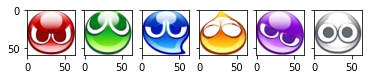

In [5]:
def get_cropped_puyos(puyo_skin: np.ndarray):
    puyos = []

    # Get colored Puyos
    for y in range(0, 72 * 5, 72):
        y0, y1 = y, y + 60
        color = []
        for x in np.arange(0, 72 * 16, 72):
            x0, x1 = x, x + 64
            color.append(puyo_skin[y0:y1, x0:x1, :])
        puyos.append(color)
    
    # Get Garbage Puyos
    y0, y1 = 72, 72 + 60
    color = []
    for x in np.arange(18 * 72, 21 * 72, 72):
        x0, x1 = x, x + 64
        color.append(puyo_skin[y0:y1, x0:x1, :])
    puyos.append(color)

    return puyos

# Test
puyos = get_cropped_puyos(puyo_skins[0])
fig, ax = plt.subplots(1, 6, sharey=True)
for i in range(len(puyos)):
    ax[i].imshow(puyos[i][0])
plt.show()

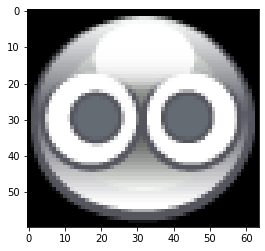

In [6]:
def alpha_blend(bg: np.ndarray, top: np.ndarray):
    '''
    https://en.wikipedia.org/wiki/Alpha_compositing#Alpha_blending
    '''
    # # Fix alpha=0 in top layer.
    # top[:, :, :3][top[:, :, 3] == 0] = 0
    
    bg = bg.astype(np.float32) / 255.0
    top = top.astype(np.float32) / 255.0
    a = top[:, :, 3]
    a = a[:, :, np.newaxis] * np.array([1, 1, 1])
    top_rgb = top[:, :, :3]
    return np.array((top_rgb * a + bg[:, :, :3] * (1 - a)) * 255, dtype=np.uint8)

test_bg = np.ones((60, 64, 4), dtype=np.uint8) * np.array([0, 0, 0, 255])
test_im = puyos[5][0]
im_a = alpha_blend(test_bg, test_im)
plt.imshow(im_a)
plt.show()

In [7]:
def get_board_cells(char_bg: np.ndarray):
    data = char_bg.reshape(-1, 4)

    cells = []
    # for p in [25, 50, 75]:
    #     percentile_color = np.percentile(data, p, axis=0).astype(np.uint8)
    #     cell = np.ones((60, 64, 4), dtype=np.uint8) * percentile_color
    #     cells.append(cell)

    for y in range(12):
        for x in range(6):
            x0, x1 = 64 * x, 64 * (x + 1)
            y0, y1 = 60 * y, 60 * (y + 1)
            cell = char_bg[y0:y1, x0:x1]
            cells.append(cell[..., :3])
    
    return np.array(cells)

cells = get_board_cells(bg_images[0])
print(cells.shape)

(72, 60, 64, 3)


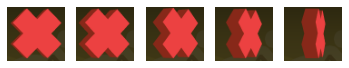

In [8]:
def get_X(cell: np.ndarray, puyo_skin: np.ndarray):
    # Get the spinning X
    y0, y1 = 72 * 11, 72 * 11 + 60
    spinning_Xes = []
    for x in np.arange(5 * 72, 10 * 72, 72):
        x0, x1 = x, x + 64
        spinning_Xes.append(puyo_skin[y0:y1, x0:x1, :])

    cells = []

    for spinner in spinning_Xes:
        cells.append(alpha_blend(cell, spinner))
    
    return cells

cells = get_board_cells(bg_images[0])
Xes = get_X(cells[2], puyo_skins[0])
fig, ax = plt.subplots(1, len(Xes))
for x in range(len(Xes)):
    ax[x].imshow(Xes[x])
    ax[x].axis('off')
plt.show()

## Generate "None"
* 24 characters
* 5 possible X icons
* 5 different types of X: ['puyo_aqua', 'puyo_degi', 'puyo_human', 'puyo_msx', 'puyo_gamegear']
* 71 possible empty cells for each character...

In [9]:
print(list(zip(np.arange(0, len(puyo_files)), puyo_files)))
skin_subset = [puyo_skins[i] for i in [0, 5, 7, 8, 11]]

[(0, 'images/puyo-skins/puyo_aqua.png'), (1, 'images/puyo-skins/puyo_beta.png'), (2, 'images/puyo-skins/puyo_block.png'), (3, 'images/puyo-skins/puyo_capsule.png'), (4, 'images/puyo-skins/puyo_classic.png'), (5, 'images/puyo-skins/puyo_degi.png'), (6, 'images/puyo-skins/puyo_fever.png'), (7, 'images/puyo-skins/puyo_gamegear.png'), (8, 'images/puyo-skins/puyo_human.png'), (9, 'images/puyo-skins/puyo_moji.png'), (10, 'images/puyo-skins/puyo_moro.png'), (11, 'images/puyo-skins/puyo_msx.png'), (12, 'images/puyo-skins/puyo_shiki.png'), (13, 'images/puyo-skins/puyo_sonic.png')]


In [10]:
# For each character, get empty cells
empty_cells = []
for bg in bg_images:
    cells = get_board_cells(bg)
    cells = cells[np.arange(0, 72) != 2]
    for cell in cells:
        empty_cells.append(cell)
print(len(empty_cells))

# For each character, get X cells
x_cells = []
for bg in bg_images:
    cells = get_board_cells(bg)
    cell = cells[2]
    for puyo_skin in skin_subset:
        Xes = get_X(cell, puyo_skin)
        for X in Xes:
            x_cells.append(X)
print(len(x_cells))

1846
650


In [11]:
empty_cells = np.array(empty_cells)
x_cells = np.array(x_cells)
print(empty_cells.shape)
print(x_cells.shape)

(1846, 60, 64, 3)
(650, 60, 64, 3)


In [12]:
none_cells = np.concatenate((empty_cells, x_cells), axis=0)
print(none_cells.shape)

(2496, 60, 64, 3)


## Generate Garbage Puyos
* 26 characters
* 14 Garbage Skins
* 3 possible garbage icons

In [15]:
garbage_puyos = []
for bg in bg_images:
    cells = get_board_cells(bg)
    mean_cell = np.mean(cells, axis=0).astype(np.uint8)
    for skin in puyo_skins:
        puyos = get_garbage_puyos(skin)
        blend = [alpha_blend(mean_cell, puyo) for puyo in puyos]
        for puyo in blend:
            garbage_puyos.append(puyo)

garbage_puyos = np.array(garbage_puyos)
print(garbage_puyos.shape)

(1092, 60, 64, 3)


## Generate Colored Puyos
Need to boost Sonic, MSX, and Human to try and improve their purple/green detection

In [16]:
aug_puyo_skins = [*puyo_skins, puyo_skins[8], puyo_skins[11], puyo_skins[13]]
puyos = np.array([get_colored_puyos(skin) for skin in aug_puyo_skins])
puyos = puyos.transpose((1, 0, 2, 3, 4, 5))
puyos = puyos.reshape((5, -1, 60, 64, 4))
print(puyos.shape)

(5, 272, 60, 64, 4)


In [17]:
print('Number of Puyos of a color: ', len(aug_puyo_skins) * 16)

Number of Puyos of a color:  272


In [18]:
# Get average color for red, green, blue, yellow, and purple characters
print(list(zip(np.arange(0, len(bg_files)), bg_files)))

[(0, 'images/char-bgs/field_alx.png'), (1, 'images/char-bgs/field_aly.png'), (2, 'images/char-bgs/field_ami.png'), (3, 'images/char-bgs/field_arl.png'), (4, 'images/char-bgs/field_car.png'), (5, 'images/char-bgs/field_cie.png'), (6, 'images/char-bgs/field_dra.png'), (7, 'images/char-bgs/field_hed.png'), (8, 'images/char-bgs/field_hra.png'), (9, 'images/char-bgs/field_hrp.png'), (10, 'images/char-bgs/field_htm.png'), (11, 'images/char-bgs/field_lgn.png'), (12, 'images/char-bgs/field_mag.png'), (13, 'images/char-bgs/field_raf.png'), (14, 'images/char-bgs/field_ris.png'), (15, 'images/char-bgs/field_rng.png'), (16, 'images/char-bgs/field_rng_2p.png'), (17, 'images/char-bgs/field_rul.png'), (18, 'images/char-bgs/field_sat.png'), (19, 'images/char-bgs/field_shz.png'), (20, 'images/char-bgs/field_sig.png'), (21, 'images/char-bgs/field_sig_2p.png'), (22, 'images/char-bgs/field_srr.png'), (23, 'images/char-bgs/field_srt.png'), (24, 'images/char-bgs/field_suk.png'), (25, 'images/char-bgs/field_

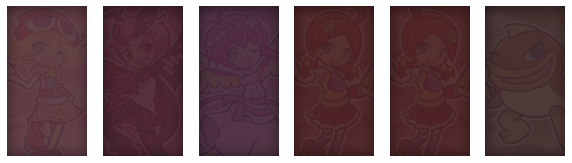

In [19]:
red_chars = np.array([bg_images[i] for i in [2, 7, 9, 15, 16, 24]])
fig, ax = plt.subplots(1, len(red_chars))
fig.set_figheight(5)
fig.set_figwidth(10)
for i in range(len(red_chars)):
    ax[i].imshow(red_chars[i])
    ax[i].axis('off')
plt.show()

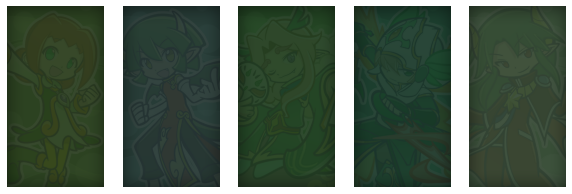

In [20]:
green_chars = np.array([bg_images[i] for i in [1, 6, 8, 10, 18]])
fig, ax = plt.subplots(1, len(green_chars))
fig.set_figheight(5)
fig.set_figwidth(10)
for i in range(len(green_chars)):
    ax[i].imshow(green_chars[i])
    ax[i].axis('off')
plt.show()

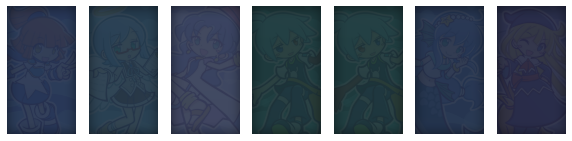

In [21]:
blue_chars = np.array([bg_images[i] for i in [3, 5, 17, 20, 21, 22, 25]])
fig, ax = plt.subplots(1, len(blue_chars))
fig.set_figheight(5)
fig.set_figwidth(10)
for i in range(len(blue_chars)):
    ax[i].imshow(blue_chars[i])
    ax[i].axis('off')
plt.show()

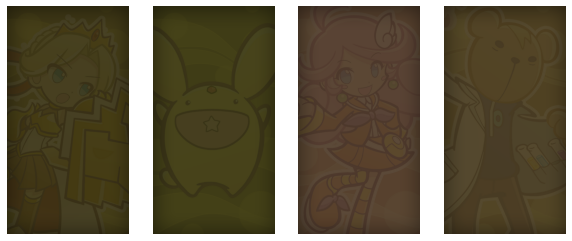

In [22]:
yellow_chars = np.array([bg_images[i] for i in [0, 4, 13, 14]])
fig, ax = plt.subplots(1, len(yellow_chars))
fig.set_figheight(5)
fig.set_figwidth(10)
for i in range(len(yellow_chars)):
    ax[i].imshow(yellow_chars[i])
    ax[i].axis('off')
plt.show()

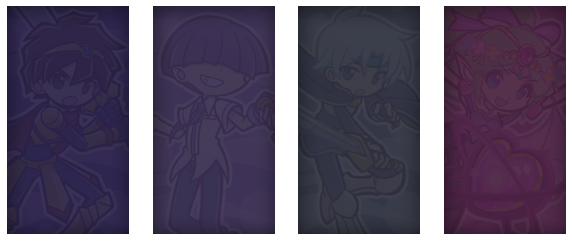

In [23]:
purple_chars = np.array([bg_images[i] for i in [11, 12, 19, 23]])
fig, ax = plt.subplots(1, len(purple_chars))
fig.set_figheight(5)
fig.set_figwidth(10)
for i in range(len(purple_chars)):
    ax[i].imshow(purple_chars[i])
    ax[i].axis('off')
plt.show()

In [24]:
mean_colors = [np.mean(chars[..., :3].reshape((-1, 3)), axis=0) for chars in [red_chars, green_chars, blue_chars, yellow_chars, purple_chars]]
mean_colors = np.array(mean_colors, dtype=np.uint8)
for n, c in zip(['red\t', 'green\t', 'blue\t', 'yellow\t', 'purple\t'], mean_colors):
    print(n, c)

red	 [77 44 51]
green	 [42 63 43]
blue	 [41 55 73]
yellow	 [71 60 32]
purple	 [58 45 72]


In [25]:
# Get all Puyos overlayed on each color
puyo_with_bg = []
for color in puyos:
    color_set = []
    for mean_bg in mean_colors:
        flat_bg = np.ones((60, 64, 3)) * mean_bg
        for puyo in color:
            color_set.append(alpha_blend(flat_bg, puyo))
    puyo_with_bg.append(color_set)
puyo_with_bg = np.array(puyo_with_bg)
print(puyo_with_bg.shape)

(5, 1360, 60, 64, 3)


## Summary of Puyo Counts so far

In [26]:
print('Empty cell:\t', none_cells.shape)
print('Garbage Puyo:\t', garbage_puyos.shape)
print('Colored Puyos:\t', puyo_with_bg.shape)

Empty cell:	 (2496, 60, 64, 3)
Garbage Puyo:	 (1092, 60, 64, 3)
Colored Puyos:	 (5, 1360, 60, 64, 3)


In [27]:
all_puyos = puyo_with_bg.transpose((1, 0, 2, 3, 4))
all_puyos = np.concatenate((all_puyos, all_puyos), axis=0)
all_puyos = all_puyos.transpose((1, 0, 2, 3, 4))
print(all_puyos.shape)

(5, 2720, 60, 64, 3)


In [28]:
need_count = 2720 - garbage_puyos.shape[0]
print('Need', need_count, 'more garbage puyos')
inds = np.arange(garbage_puyos.shape[0])
extra_inds = np.random.choice(inds, need_count, replace=True)
extra_garbage = garbage_puyos[extra_inds]
all_garbage = np.concatenate((garbage_puyos, extra_garbage), axis=0)
print(all_garbage.shape)

Need 1628 more garbage puyos
(2720, 60, 64, 3)


In [29]:
need_count = 2720 - none_cells.shape[0]
print('Need', need_count, 'more empty cells')
inds = np.arange(none_cells.shape[0])
extra_inds = np.random.choice(inds, need_count, replace=True)
extra_cells = none_cells[extra_inds]
all_empty = np.concatenate((none_cells, extra_cells), axis=0)
print(all_empty.shape)

Need 224 more empty cells
(2720, 60, 64, 3)


## Apply Torchvision Augmentations

In [30]:
from torchvision import transforms

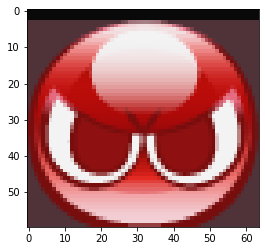

In [31]:
torch_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(0, (0.1, 0.1)),
    transforms.ColorJitter(0.1, 0.1, 0.1),
])

def apply_transform(im: np.ndarray) -> np.ndarray:
    im = torch_transforms(im)
    im = np.array(im)
    return im

test_red = apply_transform(all_puyos[0][0])
plt.imshow(test_red)

In [32]:
# Transform originals to 30x32
all_puyos_30x32 = [np.array(Image.fromarray(puyo).resize((32, 30))) for puyo in all_puyos.reshape(-1, 60, 64, 3)]
all_puyos_30x32 = np.array(all_puyos_30x32).reshape(5, -1, 30, 32, 3)
print(all_puyos_30x32.shape)

all_garbage_30x32 = [np.array(Image.fromarray(puyo).resize((32, 30))) for puyo in all_garbage]
all_garbage_30x32 = np.array(all_garbage_30x32)
print(all_garbage_30x32.shape)

all_empty_30x32 = [np.array(Image.fromarray(puyo).resize((32, 30))) for puyo in all_empty]
all_empty_30x32 = np.array(all_empty_30x32)
print(all_empty_30x32.shape)

(5, 2720, 30, 32, 3)
(2720, 30, 32, 3)
(2720, 30, 32, 3)


In [33]:
# Apply five sets of transformations

augmented_puyos = []
augmented_garbage = []
augmented_empty = []

for i in range(5):
    t_puyos = [apply_transform(puyo) for puyo in all_puyos_30x32.reshape((-1, 30, 32, 3))]
    t_puyos = np.array(t_puyos).reshape((5, -1, 30, 32, 3))
    t_garbage = [apply_transform(puyo) for puyo in all_garbage_30x32]
    t_garbage = np.array(t_garbage)
    t_empty = [apply_transform(puyo) for puyo in all_empty_30x32]
    t_empty = np.array(t_empty)
    augmented_puyos.append(t_puyos)
    augmented_garbage.append(t_garbage)
    augmented_empty.append(t_empty)

(5, 16320, 30, 32, 3)


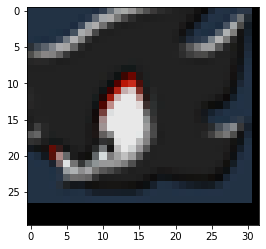

In [34]:
transformed_puyos = np.concatenate([all_puyos_30x32, *augmented_puyos], axis=1)
print(transformed_puyos.shape)
plt.imshow(transformed_puyos[1][13000])

transformed_garbage = np.concatenate([all_garbage_30x32, *augmented_garbage], axis=0)
transformed_empty = np.concatenate([all_empty_30x32, *augmented_empty], axis=0)

## Setup data for the tensors

In [35]:
# 0 = empty, 1 = garbage, 2, 3, 4, 5, 6 = rgbyp
labels = [0] * transformed_empty.shape[0]
X = np.copy(transformed_empty)
print(X.shape)

(16320, 30, 32, 3)


In [36]:
labels = labels + [1] * transformed_garbage.shape[0]
X = np.concatenate((X, transformed_garbage), axis=0)
print(X.shape)

(32640, 30, 32, 3)


In [37]:
for i in range(5):
    j = i + 2
    labels = labels + [j] * transformed_puyos[i].shape[0]
    X = np.concatenate((X, transformed_puyos[i]))

In [38]:
new_X = np.copy(X)
print(new_X.shape)

(114240, 30, 32, 3)


In [39]:
y = np.array(labels)
y.shape

(114240,)

In [41]:
import joblib
joblib.dump(new_X, "dataset-images.joblib")
joblib.dump(y, "dataset-labels.joblib")

['dataset-labels.joblib']